# SECTION 1 inclusion de packages externes 

In [66]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import ndimage as ndi
# necessite scikit-image 
from skimage import io as skio
from skimage.filters import gaussian
from skimage.segmentation import active_contour
from skimage import img_as_float
from skimage.segmentation import chan_vese
from skimage.segmentation import checkerboard_level_set
from skimage.segmentation import disk_level_set
from bokeh.plotting import figure, output_file, show
from bokeh.plotting import show as showbokeh
from bokeh.io import output_notebook
output_notebook()
plt.style.use('dark_background')


Loading BokehJS ...

In [67]:
def affiche_pour_colab(im,MINI=None, MAXI=None,titre=''): #special colab, don't look
  def normalise_image_pour_bokeh(X,MINI,MAXI):
    if MAXI==None:
      MAXI = np.max(X)
    if MINI==None:
      MINI = np.min(X)
    imt=np.copy(X.copy())
    imt=(np.clip(imt,MINI,MAXI)/(MAXI-MINI))
    imt[imt<0]=0
    imt[imt>1]=1
    imt*=255
    sortie=np.empty((*imt.shape,4),dtype=np.uint8)
    for k in range(3):
      sortie[:,:,k]=imt
    sortie[:,:,3]=255
    return sortie

  img = im
  img=normalise_image_pour_bokeh(np.flipud(im),MINI,MAXI)
  p = figure(tooltips=[("x", "$x"), ("y", "$y"), ("value", "@image")], y_range=[im.shape[0], 0], x_range=[0, im.shape[1]])
  # p.x_range.range_padding = p.y_range.range_padding = 0
  # must give a vector of images
  p.image(image=[np.flipud(im)], x=0, y=im.shape[0], dw=im.shape[1], dh=im.shape[0], palette="Greys9", level="image")
  p.xgrid.visible = False
  p.ygrid.visible = False
  showbokeh(p)

def affiche(im,MINI=0.0, MAXI=None,titre='',printname=False):
  affiche_pour_colab(im,MINI=MINI, MAXI=MAXI,titre=titre) # under google colab many options disappear

# SECTION 2 - Lecture de l'image

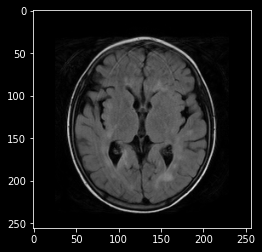

In [118]:
#im=skio.imread('coeurIRM.bmp')

#im=skio.imread('retineOA.bmp')

#im=skio.imread('brain.bmp')
#im=im[:,:,1]

im=skio.imread('brain2.bmp')

plt.imshow(im, cmap="gray")
affiche(im)

# SECTION 3a - Segmentation by contours actifs

Influence des paramètres :
- $\alpha$ va correspondre à la tendance que va avoir le contour à se rétracter. Il contrôle la taille du contour. Plus il est élevé, plus le contour va se resserer.
- $\beta$ contrôle la régularité du contour. Plus il est élevé, plus le contour va être régulier.
- $w_{edge}$ va donner la tendance que va avoir le contour à être attiré par les bords de l'image. Si on lui donne une valeur négative il va chercher à s'en éloigner.
- $w_{line}$ est la tendance au contour à être attiré par les régions claires. Si on lui donne une valeur négative il sera attiré par les régions sombres.
- $\gamma$ est le pas d'optimisation dans l'algorithme de minimisation de l'énergie.

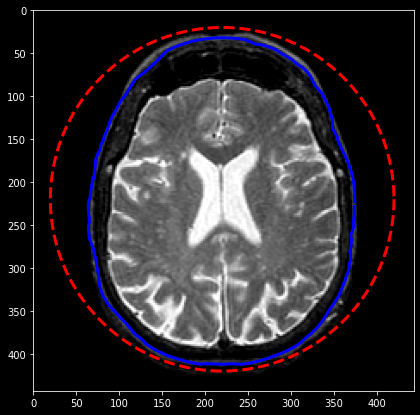

In [97]:
s = np.linspace(0, 2*np.pi, 200)
r = 220 + 200*np.sin(s)
c = 220 + 200*np.cos(s)
init = np.array([r, c]).T

#snake = active_contour(gaussian(im, 0.1),init, alpha=0.09, beta=0.1, w_edge=1.1, gamma=0.001) #Paramètres pour la boite cranienne sans l'os.


fig, ax = plt.subplots(figsize=(7, 7))
ax.imshow(im, cmap=plt.cm.gray)
ax.plot(init[:, 1], init[:, 0], '--r', lw=3)
ax.plot(snake[:, 1], snake[:, 0], '-b', lw=3)
#ax.set_xticks([]), ax.set_yticks([])
ax.axis([0, im.shape[1], im.shape[0], 0])

plt.show()

# SECTION 3b - Contours ouverts

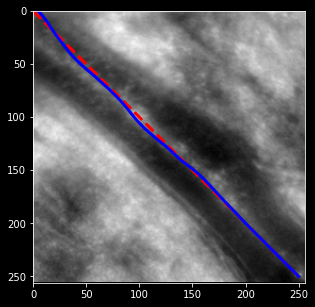

In [116]:
# Interessant sur l'image retineOA.bmp

r = np.linspace(0, 250, 100)
c = np.linspace(0, 250, 100)
init = np.array([r, c]).T

snake = active_contour(gaussian(im, 1), init,
                       alpha=1, beta=1, w_line=1, w_edge=20, gamma=0.01, boundary_condition ='free')

fig, ax = plt.subplots(figsize=(9, 5))
ax.imshow(im, cmap=plt.cm.gray)
ax.plot(init[:, 1], init[:, 0], '--r', lw=3)
ax.plot(snake[:, 1], snake[:, 0], '-b', lw=3)
#ax.set_xticks([]), ax.set_yticks([])
ax.axis([0, im.shape[1], im.shape[0], 0])

plt.show()

# SECTION 4 - Segmentation par ensembles de niveaux

Influence des paramètres : 
- $\mu$ correspond à la 'longueur' du contour. Plus il est élevé, plus le contour sera rond et plus il est proche de zéro plus il parviendra à capturer des détails.
- $\lambda_1$ (respectivement $\lambda_2$) correspond à la taille de la région segmenté (respectivement l'arrère-plan) et son écart à la moyenne de l'image. Si le premier est plus grand que le second, alors la région correspondante sera plus grande et inversement.
Les autres paramètres sont des critères d'arrêt ou d'optimisation.

C:\Users\blanc\AppData\Local\Temp\ipykernel_18044\2653298553.py:21: FutureWarning: `max_iter` is a deprecated argument name for `chan_vese`. It will be removed in version 1.0.Please use `max_num_iter` instead.
  cv = chan_vese(image, mu=0.24, lambda1=5, lambda2=1, tol=1e-3, max_iter=400,


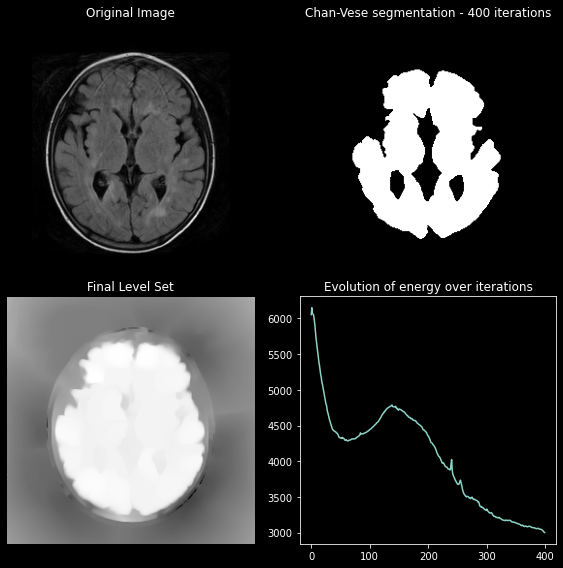

In [141]:
image = img_as_float(im)

# Init avec un damier
init_ls = checkerboard_level_set(image.shape, 6)

# Init avec un cercle
#init_ls = circle_level_set (image.shape, (120,130), 10)

# Init avec plusieurs cercles
circleNum = 8
circleRadius = image.shape[0] / (3*circleNum)
circleStep0 = image.shape[0]/(circleNum+1)
circleStep1 = image.shape[1]/(circleNum+1)
init_ls = np.zeros(image.shape)
for i in range(circleNum):
        for j in range(circleNum):
            init_ls = init_ls + disk_level_set (image.shape, 
                                                  center = ((i+1)*circleStep0, (j+1)*circleStep1), radius=circleRadius)


cv = chan_vese(image, mu=0.24, lambda1=5, lambda2=1, tol=1e-3, max_iter=400,
               dt=0.5, init_level_set=init_ls, extended_output=True)

fig, axes = plt.subplots(2, 2, figsize=(8, 8))
ax = axes.flatten()

ax[0].imshow(image, cmap="gray")
ax[0].set_axis_off()
ax[0].set_title("Original Image", fontsize=12)

ax[1].imshow(cv[0], cmap="gray")
ax[1].set_axis_off()
title = "Chan-Vese segmentation - {} iterations".format(len(cv[2]))
ax[1].set_title(title, fontsize=12)

ax[2].imshow(cv[1], cmap="gray")
ax[2].set_axis_off()
ax[2].set_title("Final Level Set", fontsize=12)

ax[3].plot(cv[2])
ax[3].set_title("Evolution of energy over iterations", fontsize=12)

fig.tight_layout()
plt.show()

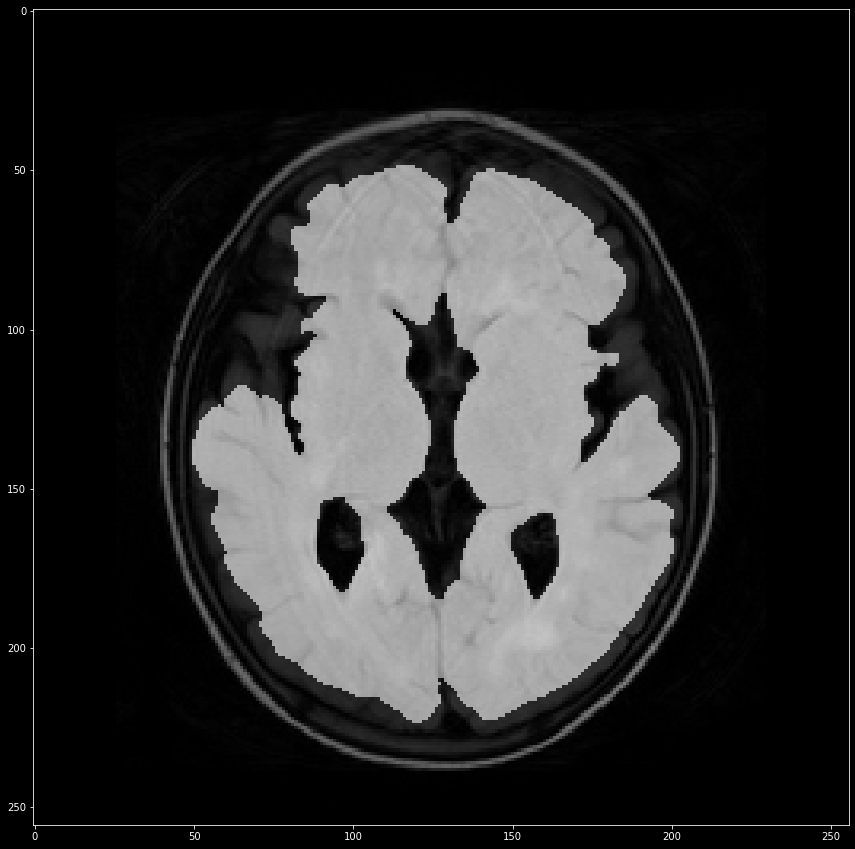

In [142]:
plt.figure(figsize=(15,15))
plt.imshow(im,cmap='gray')
plt.imshow(cv[0],alpha=0.5,cmap='gray')